# NYC Airbnb Dataset Price Prediction

### Description
This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data >New York City Airbnb Open Data</a>. The dataset is under public domain license (v10.0).


### Purpose
The purpose of this notebook is to showcase various data processing and estimating techniques based on the NYC Airbnb dataset. For the target variable, daily Airbnb rental prices were selected. Our goal is to create a model that predicts the target feature reasonably well based on the 9 independent variables:
 
1. Host Id
2. Host name
3. Latitude
4. Longitude
5. Minimum nights
6. Number of reviews
7. Reviews per month
8. Calculated host listing count
9. Availability 

To achieve reliable predictions we will use the following techniques: Multiple Linear Regression, DNN Regression and XGBoost.
#### Contact

[![LinkedIn](https://img.shields.io/badge/linkedin-%230077B5.svg?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/m-nemeth/)
[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/marci-nemeth)
[![Kaggle](https://img.shields.io/badge/Kaggle-035a7d?style=for-the-badge&logo=kaggle&logoColor=white)](https://www.kaggle.com/marcellnmeth)


#### Packages used:
![Keras](https://img.shields.io/badge/Keras-%23D00000.svg?style=for-the-badge&logo=Keras&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=for-the-badge&logo=Matplotlib&logoColor=black)
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white)
![Pandas](https://img.shields.io/badge/pandas-%23150458.svg?style=for-the-badge&logo=pandas&logoColor=white)
![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white)
![TensorFlow](https://img.shields.io/badge/TensorFlow-%23FF6F00.svg?style=for-the-badge&logo=TensorFlow&logoColor=white)

#### To-Do


---

## Table of contents
1. [Dataset](#1-dataset)
   
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
   
   2.1 [Distribution by neighborhood](#21-distribution-of-features-by-neigborhoud-groups)

   2.2 [Plotting Heatmap](#22-plotting-latitude-and-longitude-on-nyc-map)

   2.3 [Missing Values](#23-missing-values)
   
   2.4 [Correlation of Features](#24-inter-correlation-of-features)

   2.5 [Distribution of variables](#25-distribution-of-variables)
   
3. [Data Preparation](#3-refining-the-data)
   
    3.1 [Basic Preparations](#31-basic-preparations)

    3.2 [Log transform features](#32-log-transform-features-with-high-skewness-and-kurtosis)

4. [Regression Models](#4-regression-models)
   
   4.1 [Multiple Linear Regression](#41-multiple-linear-regression)

   4.2 [LASSO Regression](#42-lasso-regression)

   4.3 [Ridge Regression](#43-ridge-regression)

   4.2 [Random Forest](#44-random-forest)

   4.3 [DNN Regression](#45-dnn-regression)

   4.4 [XGB Regression](#46-xgboost)

5. [Hyper-parameter tuning](#5-hyper-parameter-tuning-with-randomizedsearchcv)
6. [Model Comparison](#6-model-comparison)
7. [Conclusion](#7-conclusion)
8. [Sources](#8-sources)

<a id='dataset'></a>

## 1. Dataset

In [277]:
import zipfile
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from scipy import stats
import tensorflow as tf
from matplotlib import transforms
from scipy.stats import gaussian_kde
from scipy import stats
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from tensorflow import keras
from xgboost import XGBClassifier,XGBRegressor
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso,Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

In [278]:
df = pd.read_csv("data/AB_NYC_2019.csv",index_col=0)

In [279]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


<a id='eda'></a>

## 2. Exploratory Data Analysis

In [280]:
eda_df = df.copy()

for c in ["price","minimum_nights","number_of_reviews"]:
    eda_df = eda_df[(np.abs(stats.zscore(df[c])) < 2)]

### 2.1. Distribution of features by neigborhoud groups

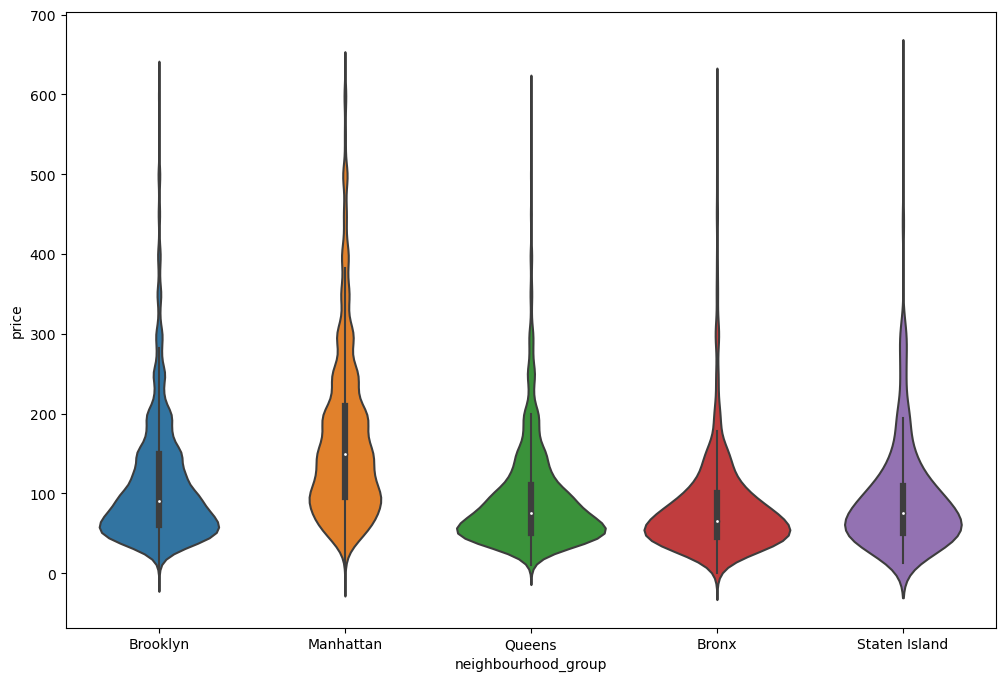

In [281]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(x="neighbourhood_group", y="price", data=eda_df)
plt.show()

### 2.2. Plotting latitude and longitude on NYC map (encoding neighborhoods)

In [282]:
encoder = LabelEncoder()
to_encode = ["neighbourhood","neighbourhood_group","room_type"]
eda_df[to_encode]= eda_df[to_encode].apply(encoder.fit_transform)

<Figure size 640x480 with 0 Axes>

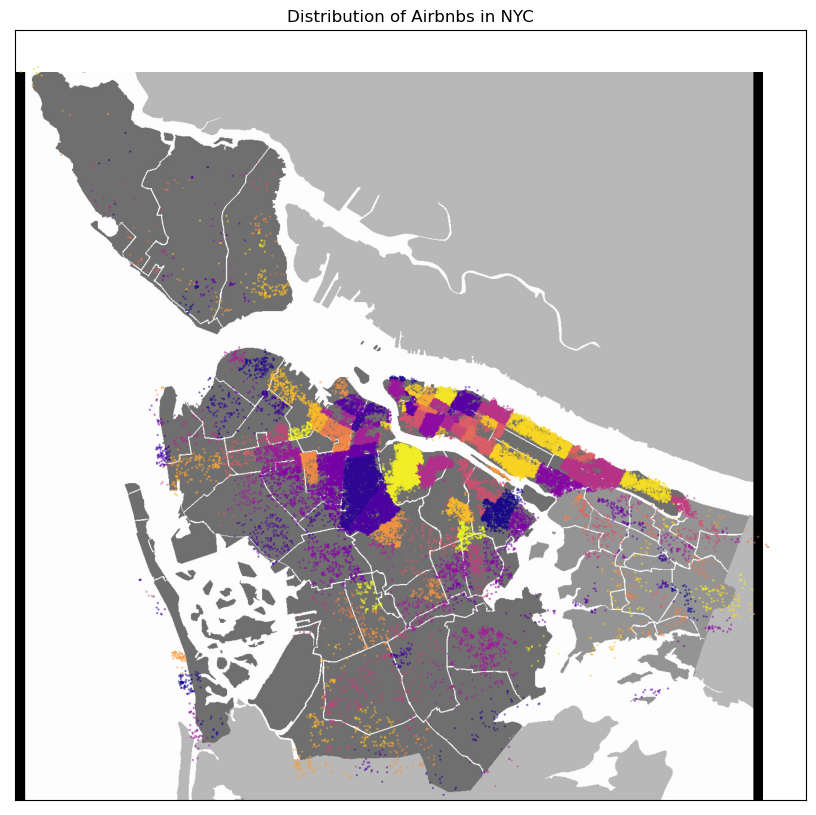

In [283]:
img = Image.open("data/New_York_City_.jpeg").rotate(270)
plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
width,height = img.size
transp_lat =(eda_df["latitude"]-eda_df["latitude"].min())/(eda_df["latitude"].max()-eda_df["latitude"].min())*width
transp_long =(eda_df["longitude"]-eda_df["longitude"].min())/(eda_df["longitude"].max()-eda_df["longitude"].min())*height
ax.imshow(img);
colors = (eda_df["price"]-eda_df["price"].min())/(eda_df["price"].max()-eda_df["price"].min())
ax.scatter(transp_lat+10,transp_long-10, c=eda_df["neighbourhood"],alpha=0.5,cmap="plasma",s=0.4);
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_title("Distribution of Airbnbs in NYC");

### 2.3. Missing Values

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64


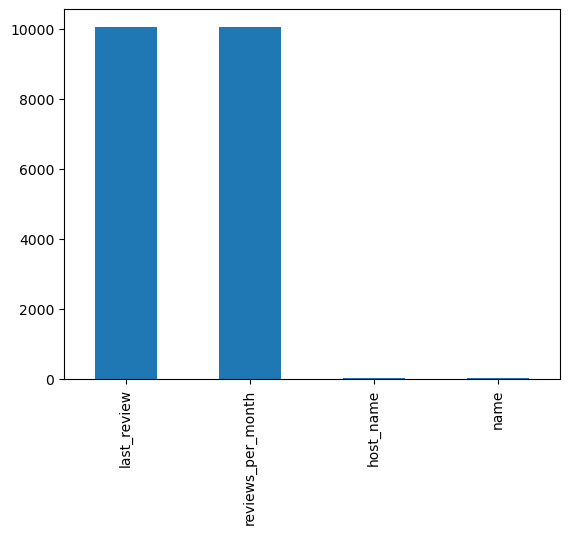

In [284]:
missing = pd.isna(df).sum().sort_values(ascending=False)
print(missing[missing>0])
missing[missing >0].plot.bar();

### 2.4 Inter-correlation of features

Plotting a correlation matrix of the quantitative features can help establish grounds for feature engineering or exclusion of variables. In this case Pearson's correlation coefficients are weak or non-existent, therefore we can leave them as-is.

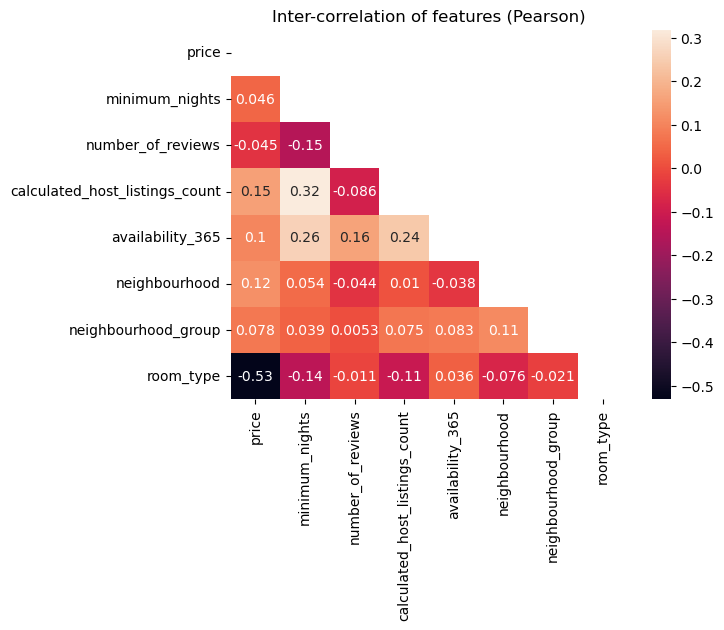

In [285]:
corr_mat = eda_df[["price","minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365","neighbourhood","neighbourhood_group","room_type"]].corr()

ax = plt.axes()
matrix = np.triu(corr_mat)
sns.heatmap(corr_mat,annot=True, ax = ax,mask=matrix)
ax.set_title('Inter-correlation of features (Pearson)')
plt.show()

**Inter-correlation of variables:**

    - room_type - price: -0.53
    - minimum_nights - calculated_host_listing_counts: 0.32
    - price - calculated_host_listing_counts: 0.15
    - price -neighborhood: 0.12

In [286]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

#### 2.5 Distribution of variables

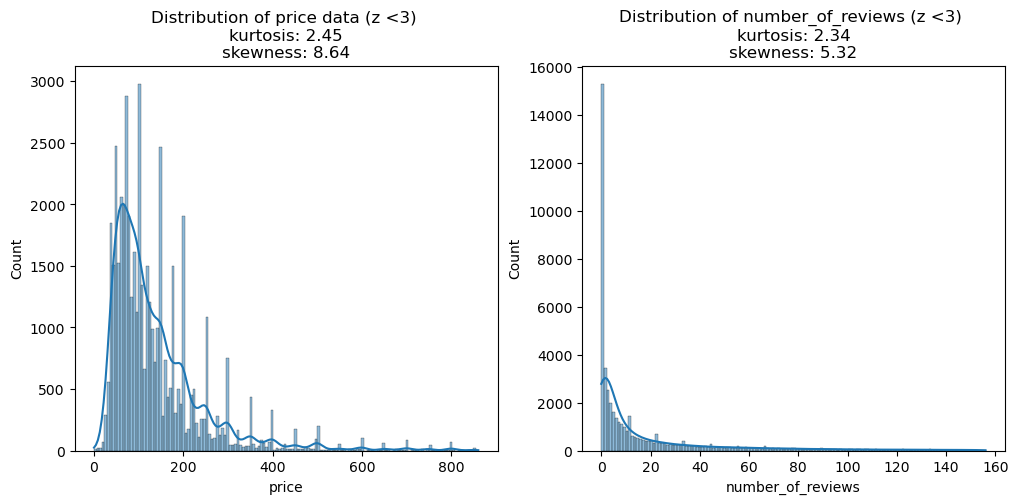

In [287]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

sns.histplot(df[stats.zscore(df["price"])<3]["price"],ax=ax1,kde="gausian")
sns.histplot(df[stats.zscore(df["number_of_reviews"])<3]["number_of_reviews"],ax=ax2,kde="gausian")
ax1.set_title("Distribution of price data (z <3) \nkurtosis: {:.2f}\nskewness: {:.2f}".format(df[stats.zscore(df["price"])<3]["price"].skew(),
                                                                                                       df[stats.zscore(df["price"])<3]["price"].kurt()))

ax2.set_title("Distribution of number_of_reviews (z <3) \nkurtosis: {:.2f}\nskewness: {:.2f}".format(df[stats.zscore(df["number_of_reviews"])<3]["number_of_reviews"].skew(),
                                                                                                       df[stats.zscore(df["number_of_reviews"])<3]["number_of_reviews"].kurt()))
plt.show()

It can be noted that both features have high kurtosis and skewness. We will deal with this in part 3.

<a id='data_ref'></a>

### 3. Refining the data

### 3.1. Basic preparations

**3.1. Removing Nan values from rows**

In [288]:

df = df.dropna()
df = df.drop(["name","host_id","host_name","last_review"],axis=1)

**No such thing as free apartment (removing where price = 0 for log transformation)**

In [289]:
print("Removing {} points due to no price data".format(len(df[df["price"] == 0])))
df = df[df["price"]!=0]

Removing 10 points due to no price data


#### 3.2 Log transform features with high skewness and kurtosis

In [290]:
for c in ["price","minimum_nights","number_of_reviews","reviews_per_month"]:
    print("{}\n\tKurt:{}\n\tSkew:{}".format(c,df[c].kurt(),df[c].skew()))

price
	Kurt:953.4739828140484
	Skew:23.67486065114248
minimum_nights
	Kurt:1381.5721712543975
	Skew:27.543112694557543
number_of_reviews
	Kurt:15.968772696319137
	Skew:3.3257465660811163
reviews_per_month
	Kurt:42.545951351923414
	Skew:3.1324387470787585


In [291]:
for c in ["price","minimum_nights","number_of_reviews","reviews_per_month"]:
    df[c] = np.log(df[c])
    print("Log {}\n\tKurt:{}\n\tSkew:{}".format(c,df[c].kurt(),df[c].skew()))

Log price
	Kurt:1.0042615755971878
	Skew:0.514325760538284
Log minimum_nights
	Kurt:1.492829881831487
	Skew:1.2316560929465632
Log number_of_reviews
	Kurt:-0.9548324397948686
	Skew:0.1453166096243965
Log reviews_per_month
	Kurt:-0.7264399797736081
	Skew:-0.3968892690295266


**3.2. Encoding categorical variables**

In [292]:
encoder = LabelEncoder()
to_encode = ["neighbourhood","neighbourhood_group","room_type"]
df[to_encode]= df[to_encode].apply(encoder.fit_transform)

**3.3 Splitting data to train and test set with label: price**

In [293]:
y = df.pop("price")
X = df

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [294]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(31048, 10) (7763, 10) (31048,) (7763,)


**3.4. Adding keras.Normalization layer**

In [295]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

<a id='slr'></a>

## 4. Regression Models

#### 4.1 Multiple Linear Regression

Multiple regression with 11 input variables (due to one-hot-encoding). 

$ Y_i= \beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...+\beta_{n}X_{ni}+u_i$

where:

$ Y_i $ : dependent variable

$ \beta_i $ : Y intercept

$ \beta_1 ... \beta_n $ : regression coefficients

$ X_{1i} ... X_{ni} $ : independent variables s.t. $ n = 11 $

$ u_i $ : error


In [296]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [297]:
lr_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
lr_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 32
Trainable params: 11
Non-trainable params: 21
_________________________________________________________________


In [298]:
lr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

lr_history = lr_model.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=0,
    validation_split = 0.2)


In [299]:
y_hat = lr_model.predict(X_test)


243/243 [==============================] - 0s 724us/step


In [300]:
print(y_hat.flatten())
print(y_test.to_numpy())
print(mean_absolute_error(y_test.to_numpy(),y_hat.flatten()))

[5.2487063 4.4092326 4.558159  ... 4.229936  4.8375025 5.0444155]
[5.14749448 3.71357207 4.67282883 ... 4.15888308 5.0689042  4.38202663]
0.3941943689266918


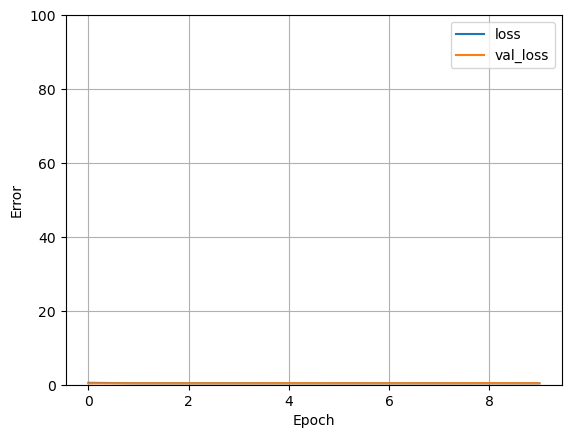

In [301]:
plot_loss(lr_history)

<a id='dnn'></a>

#### 4.2 Lasso Regression

Least Absolute Shrinkage and Selection Operator

Linear regression that also reduces number of input features.

Also called L1-norm regularization

Different loss function to LR:

LR Loss:

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} Cost(h_{\theta}(x^{(i)}),y^{(i)})+\frac{\lambda}{m} $$

LASSO Loss:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} Cost(h_{\theta}(x^{(i)}),y^{(i)})+\frac{\lambda}{m} + \sum_{j=1}^{n} abs(\theta_j) $$

$\sum_{j=1}^{n} abs(\theta_j)$:
Regularization parameter with absolute sum of weight values

In [302]:
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train,y_train)

Lasso()

#### 4.3 Ridge Regression

L2-norm regularization

**L2 Penalty:** Penalize the model based on the sum square coefficient ($\beta$).
$$l2_{penalty} = \sum_{j=0}^p \beta_j^2$$

**Lambda ($\lambda$):** hyper-param that controls weighting of l2 penalty s.t.:

$$ridge_{loss} = loss + (\lambda * l2_{penalty})$$

In [303]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train,y_train)

Ridge()

#### 4.4 Random Forest

In [304]:
rf_model = RandomForestRegressor(n_estimators= 100)

rf_model.fit(X_train,y_train)

RandomForestRegressor()

#### 4.5 DNN Regression

Simple Deep Neural Network estimator in the form:

Normalizer Layer -> Hidden Layer 1 -> Hidden Layer 2 -> Output Layer

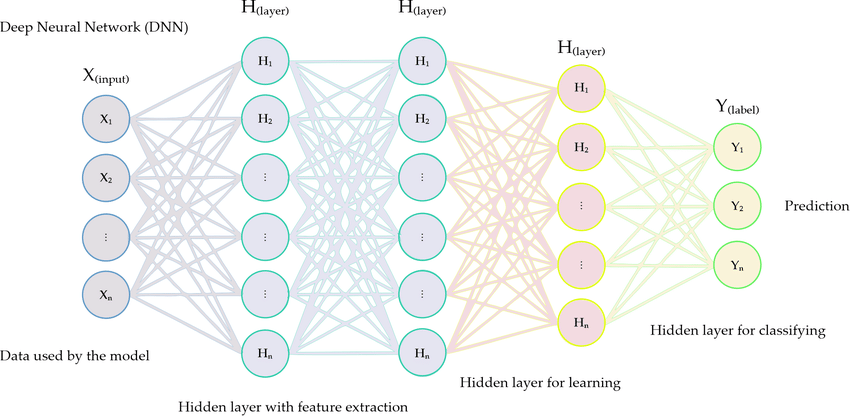

*Source: https://www.researchgate.net/publication/348688002/figure/fig1/AS:982812253487104@1611332109586/A-DNN-architecture-This-is-a-simple-example-of-how-a-DNN-may-be-built-Here-the-initial.ppm*

In [305]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [306]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 32)                352       
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,462
Trainable params: 1,441
Non-trainable params: 21
_________________________________________________________________


In [307]:
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=10)

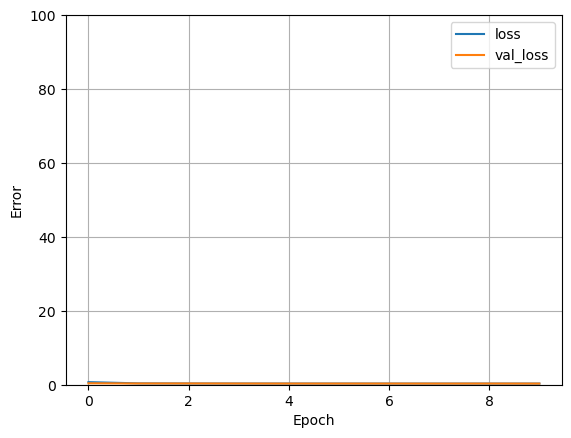

In [308]:
plot_loss(dnn_history)

<a id='xgb'></a>

#### 4.6 XGBoost

Another, more advanced technique is XGBoost, which performed better than regression in previous Kaggle competitions so let's give it a shot. We will use Scikit-Learn's grid search method to tune hyperparams. 

In [309]:
xgb_model = XGBRegressor(booster="gbtree",min_child_weight=5,max_depth=3)
xgb_history = xgb_model.fit(X_train, y_train)

## 5. Hyper-parameter tuning with RandomizedSearchCV
The estimators that can be cross-validated are Random Forest, XGBoost, Ridge and Lasso.

A randomized search helps to find optimal solutions quicker than grid search, as the latter takes hours.

In [310]:
from sklearn.model_selection import RandomizedSearchCV
def do_cv_rf():
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    rf_random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    reg_rf = RandomizedSearchCV(estimator = rf_model, param_distributions = rf_random_grid
                                , n_iter = 10, cv = 3, verbose=3, random_state=42, n_jobs = -1)

    rf_result = reg_rf.fit(X_train,y_train)

    return rf_result.best_params_

In [311]:
rf_best_params = {'n_estimators': 1927, 
 'min_samples_split': 5, 
 'min_samples_leaf': 2, 
 'max_features': 'sqrt', 
 'max_depth': 52, 
 'bootstrap': True}

In [312]:
def do_cv_xgb():    
    lr = [x for x in np.arange(start=0.05,stop=0.15,step=0.05)]
    max_depth = [int(x) for x in np.arange(start=2,stop=8,step=2)]
    min_child_w = [int(x) for x in np.arange(start=1,stop=7,step=2)]
    gamma = [x for x in np.arange(start=0.0,stop=0.2,step=0.1)]
    colsample = [x for x in np.arange(start=0.3,stop=0.4,step=0.1)]


    xgb_param_grid ={"learning_rate": lr,
        "max_depth": max_depth,
        "min_child_weight": min_child_w,
        "gamma":gamma,
        "colsample_bytree":colsample,}


    reg_xgb = RandomizedSearchCV(estimator=xgb_model,param_distributions=xgb_param_grid, 
                                n_iter = 10, cv = 3, verbose=3, random_state=42, n_jobs = -1)

    xgb_result = reg_xgb.fit(X_train,y_train)

    return xgb_result.best_params_


<a id='comparison'></a>

In [313]:
xgb_best_params = {'min_child_weight': 5, 
                   'max_depth': 6, 
                   'learning_rate': 0.05, 
                   'gamma': 0.1, 
                   'colsample_bytree': 0.4}

In [314]:
opt_xgb = XGBRegressor(**xgb_best_params)
opt_xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [315]:
opt_rf = RandomForestRegressor(**rf_best_params)
opt_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=52, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1927)

#### Alpha optimization for Ridge and Lasso

In [316]:
def l1_cv(estimator):
    kf = KFold(5, shuffle=True, random_state = 42).get_n_splits(X_train)
    return cross_val_score(estimator, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)


In [317]:
alphas = [0.05, 0.1, 0.15,0.2,0.25,0.3] 
cv_ridge1 = [-l1_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas)

cv_ridge2 = [-l1_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge2 = pd.Series(cv_ridge2, index = alphas)

Text(0, 0.5, 'rmse')

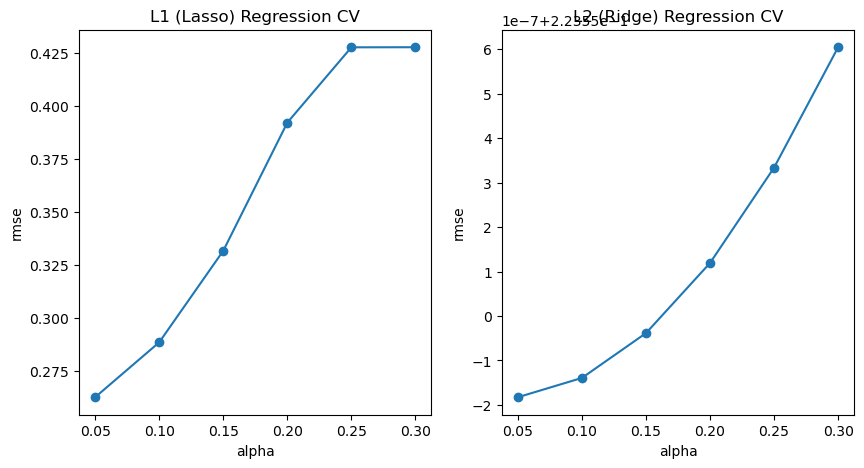

In [318]:
fig, axes = plt.subplots(1,2,figsize=(10, 5))
cv_ridge1.plot(title = "L1 (Lasso) Regression CV", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
# axes[0].set_xscale('log')

cv_ridge2.plot(title = "L2 (Ridge) Regression CV", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
# axes[1].set_xscale('log');

Optimal alpha for Lasso: ~0.05 

Optimal alpha for Ridge: ~0.05

**What does this tell us?**

As the optimal alpha approaches 0, the model is technically approaching the Multiple Linear Regression model as no regularization takes place.

In [319]:
opt_lasso = Lasso(alpha=0.005).fit(X_train,y_train)
opt_ridge = Ridge(alpha=0.005).fit(X_train,y_train)

## 6. Model Comparison

In [320]:
y_pred_rf = opt_rf.predict(X_test)
y_pred_xgb = opt_xgb.predict(X_test)
y_pred_slr = lr_model.predict(X_test)
y_pred_dnn = dnn_model.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)

243/243 [==============================] - 0s 1ms/step


In [321]:
print(y_test.to_numpy().shape)
print(y_pred_xgb.flatten().shape)

(7763,)
(7763,)


In [322]:
mae_dnn = mean_absolute_error(y_test.to_numpy(),y_pred_dnn.flatten())
mae_xgb =mean_absolute_error(y_test.to_numpy(),y_pred_xgb.flatten())
mae_slr = mean_absolute_error(y_test.to_numpy(),y_pred_slr.flatten())
mae_rf = mean_absolute_error(y_test.to_numpy(),y_pred_rf.flatten())
mae_lasso = mean_absolute_error(y_test.to_numpy(),y_pred_lasso.flatten())
mae_ridge = mean_absolute_error(y_test.to_numpy(),y_pred_ridge.flatten())

r2_dnn = r2_score(y_test.to_numpy(),y_pred_dnn.flatten())
r2_xgb =r2_score(y_test.to_numpy(),y_pred_xgb.flatten())
r2_slr = r2_score(y_test.to_numpy(),y_pred_slr.flatten())
r2_rf = r2_score(y_test.to_numpy(),y_pred_rf.flatten())
r2_lasso = r2_score(y_test.to_numpy(),y_pred_lasso.flatten())
r2_ridge = r2_score(y_test.to_numpy(),y_pred_ridge.flatten())

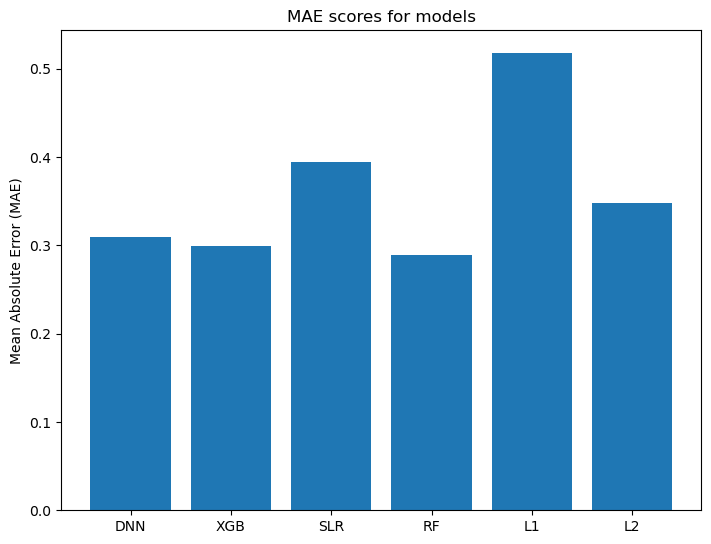

In [323]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(["DNN","XGB","SLR","RF","L1","L2"],[mae_dnn,mae_xgb,mae_slr,mae_rf,mae_lasso,mae_ridge])
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("MAE scores for models");

In [324]:
print("r2 score for XGB: {:.2f}\tMAE: {:.2f}".format(r2_xgb,mae_xgb))
print("r2 score for DNN: {:.2f}\tMAE: {:.2f}".format(r2_dnn,mae_dnn))
print("r2 score for SLR: {:.2f}\tMAE: {:.2f}".format(r2_slr,mae_slr))
print("r2 score for RF: {:.2f}\tMAE: {:.2f}".format(r2_rf,mae_rf))
print("r2 score for L1: {:.2f}\tMAE: {:.2f}".format(r2_lasso,mae_lasso))
print("r2 score for L2: {:.2f}\tMAE: {:.2f}".format(r2_ridge,mae_ridge))

r2 score for XGB: 0.61	MAE: 0.30
r2 score for DNN: 0.59	MAE: 0.31
r2 score for SLR: 0.38	MAE: 0.39
r2 score for RF: 0.64	MAE: 0.29
r2 score for L1: 0.03	MAE: 0.52
r2 score for L2: 0.49	MAE: 0.35


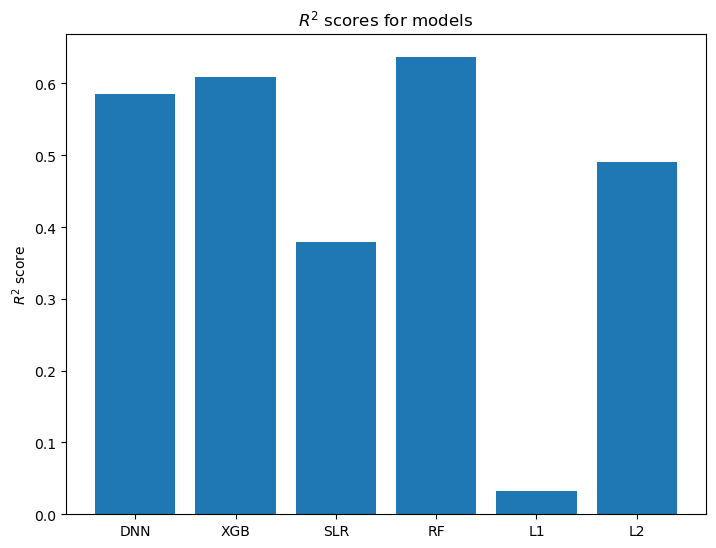

In [325]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(["DNN","XGB","SLR","RF","L1","L2"],[r2_dnn,r2_xgb,r2_slr,r2_rf,r2_lasso,r2_ridge])
ax.set_ylabel("$R^2$ score")
ax.set_title("$R^2$ scores for models");

## 7. Conclusion

This notebook was created to showcase regression methods used to predict continuos data such as in this Kaggle dataset. Six basic statistical models were tested after feature engineering the data so it fits the requirements for regression analysis.
 
The best performing model according to both Mean Squared Error and $R^2$ scores is the Random Forest Regressor (MAE: 0.29, $R^2$: 0.64).

Ideas for future analysis:

- Sentiment analysis of last review
- Transform learning from other datasets
- Mapping apartments to hosts

## 8. Sources

It goes without saying that as any of my notebook collections, this is also just a notebook that helps me reference different data analysis methods in python. 
Most methods used in this notebook are inspired by other Kaggle competitors notebooks.
To mention a few:

- <a href=https://www.kaggle.com/code/jrw2200/smart-pricing-with-xgb-rfr-interpretations>Smart Pricing with XGB RFR interpretations (Andrew W)</a>

Thanks for reading!